# Emulators: First example

This example illustrates Bayesian inference on a time series, using [Adaptive Covariance MCMC](http://pints.readthedocs.io/en/latest/mcmc_samplers/adaptive_covariance_mcmc.html) with emulator neural networks .

It follows on from [Sampling: First example](../sampling/first-example.ipynb)

Like in the sampling example, I start by importing pints:

In [1]:
import pints

C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passi

Next, I create a model class using the "Logistic" toy model included in pints:

In [2]:
import pints.toy as toy

class RescaledModel(pints.ForwardModel):
    def __init__(self):
        self.base_model = toy.LogisticModel()
    
    def simulate(self, parameters, times):
        # Run a simulation with the given parameters for the
        # given times and return the simulated values
        r, k = parameters
        r = r / 50
        k = k * 500
        return self.base_model.simulate([r, k], times)
    
    def simulateS1(self, parameters, times):
        # Run a simulation with the given parameters for the
        # given times and return the simulated values
        r, k = parameters
        r = r / 50
        k = k * 500
        return self.base_model.simulateS1([r, k], times)
    
    def n_parameters(self):
        # Return the dimension of the parameter vector
        return 2

# Rescale parameters
#found_parameters = list(found_parameters)
#found_parameters[0] = found_parameters[0] / 50
#found_parameters[1] = found_parameters[1] * 500

# Show score of true solution
#print('Score at true solution: ')
#print(score(true_parameters))

# Compare parameters with original
#print('Found solution:          True parameters:' )
#for k, x in enumerate(found_parameters):
    #print(pints.strfloat(x) + '    ' + pints.strfloat(true_parameters[k]))
    
model = toy.LogisticModel()

In order to generate some test data, I choose an arbitrary set of "true" parameters:

In [3]:
true_parameters = [0.015, 500]
start_parameters = [0.75, 1.0]

And a number of time points at which to sample the time series:

In [4]:
import numpy as np
times = np.linspace(0, 1000, 400)

Using these parameters and time points, I generate an example dataset:

In [5]:
org_values = model.simulate(true_parameters, times)
range_values = max(org_values) - min(org_values)

And make it more realistic by adding gaussian noise:

In [6]:
noise = 0.05 * range_values
print("The noise is:", noise)
values = org_values + np.random.normal(0, noise, org_values.shape)
values = org_values + np.random.normal(0, noise, org_values.shape)

The noise is: 24.898095903089327


Using matplotlib, I look at the noisy time series I just simulated:

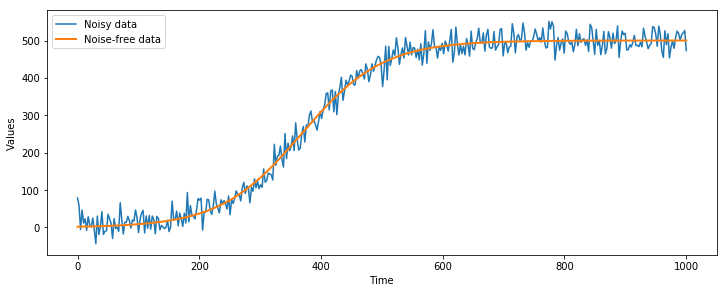

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4.5))
plt.xlabel('Time')
plt.ylabel('Values')
plt.plot(times, values, label='Noisy data')
plt.plot(times, org_values, lw=2, label='Noise-free data')
plt.legend()
plt.show()

Now, I have enough data (a model, a list of times, and a list of values) to formulate a PINTS problem:

In [8]:
model = RescaledModel()
problem = pints.SingleOutputProblem(model, times, values)

I now have some toy data, and a model that can be used for forward simulations. To make it into a probabilistic problem, a _noise model_ needs to be added. This can be done using the `GaussianLogLikelihood` function, which assumes independently distributed Gaussian noise over the data, and can calculate log-likelihoods:

In [9]:
#log_likelihood = pints.GaussianLogLikelihood(problem)
log_likelihood = pints.GaussianKnownSigmaLogLikelihood(problem, noise)

This `log_likelihood` represents the _conditional probability_ $p(y|\theta)$, given a set of parameters $\theta$ and a series of $y=$ `values`, it can calculate the probability of finding those values if the real parameters are $\theta$.

This can be used in a Bayesian inference scheme to find the quantity of interest:

$p(\theta|y) = \frac{p(\theta)p(y|\theta)}{p(y)} \propto p(\theta)p(y|\theta)$

To solve this, a _prior_ is defined, indicating an initial guess about what the parameters should be. 
Similarly as using a _log-likelihood_ (the natural logarithm of a likelihood), this is defined by using a _log-prior_. Hence, the above equation simplifies to:

$\log p(\theta|y) \propto \log p(\theta) + \log p(y|\theta)$

In this example, it is assumed that we don't know too much about the prior except lower and upper bounds for each variable: We assume the first model parameter is somewhere on the interval $[0.01, 0.02]$, the second model parameter on $[400, 600]$, and the standard deviation of the noise is somewhere on $[1, 100]$.

In [10]:
# Create bounds for our parameters and get prior
#bounds = pints.RectangularBoundaries([0.01, 400], [0.02, 600])
bounds = pints.RectangularBoundaries([0.5, 0.8], [1.0, 1.2])
log_prior = pints.UniformLogPrior(bounds)

With this prior, the numerator of Bayes' rule can be defined -- the unnormalised log posterior, $\log \left[ p(y|\theta) p(\theta) \right]$, which is the natural logarithm of the likelihood times the prior:

In [11]:
# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

Finally we create a list of guesses to use as initial positions. We'll run three MCMC chains so we create three initial positions:

In [12]:
xs = [
    np.array(start_parameters) * 0.9,
    np.array(start_parameters) * 1.05,
    np.array(start_parameters) * 1.15,
]

And this gives us everything we need to run an MCMC routine:

In [13]:
chains = pints.mcmc_sample(log_posterior, 3, xs)

Using Haario-Bardenet adaptive covariance MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0
1     6      0.5       0         0          0:00.0
2     9      0.333     0.333     0          0:00.0
3     12     0.25      0.25      0          0:00.0
20    63     0.143     0.0476    0.19       0:00.0
40    123    0.0732    0.0488    0.0976     0:00.1
60    183    0.0656    0.0328    0.0656     0:00.1
80    243    0.0494    0.037     0.0494     0:00.1
100   303    0.0396    0.0297    0.0396     0:00.1
120   363    0.0413    0.0248    0.0331     0:00.1
140   423    0.0355    0.0284    0.0284     0:00.1
160   483    0.0311    0.0248    0.0248     0:00.2
180   543    0.0276    0.0276    0.0221     0:00.2
Initial phase completed.
200   603    0.0249    0.0249    0.0199     0:00.2
220   663    0.0452    0.0498    0.0407     0:00.2
240   723    0.0954    0.083     0.0705     0:00.2
260   783   

3100  9303   0.218     0.225     0.232      0:03.1
3120  9363   0.218     0.225     0.232      0:03.1
3140  9423   0.217765  0.224     0.232      0:03.1
3160  9483   0.217969  0.223     0.232      0:03.2
3180  9543   0.217856  0.223     0.230745   0:03.2
3200  9603   0.217     0.223     0.231      0:03.2
3220  9663   0.218     0.224     0.23       0:03.2
3240  9723   0.217834  0.223     0.23       0:03.2
3260  9783   0.218     0.224     0.231      0:03.2
3280  9843   0.218     0.224     0.23       0:03.3
3300  9903   0.217     0.224     0.231      0:03.3
3320  9963   0.217     0.225     0.232159   0:03.3
3340  10023  0.217     0.225     0.232      0:03.3
3360  10083  0.217     0.225     0.232      0:03.3
3380  10143  0.218     0.224     0.231      0:03.4
3400  10203  0.219     0.225     0.231      0:03.4
3420  10263  0.218     0.224     0.231      0:03.4
3440  10323  0.219     0.224644  0.231      0:03.4
3460  10383  0.218434  0.224     0.23       0:03.4
3480  10443  0.218     0.223499

6480  19443  0.228     0.23      0.231      0:06.4
6500  19503  0.228     0.23      0.232      0:06.5
6520  19563  0.228     0.23      0.231      0:06.5
6540  19623  0.228     0.23024   0.231      0:06.5
6560  19683  0.228     0.231     0.232      0:06.5
6580  19743  0.228     0.23      0.232      0:06.5
6600  19803  0.228     0.23      0.232995   0:06.6
6620  19863  0.228     0.23      0.233      0:06.6
6640  19923  0.228     0.23      0.233      0:06.6
6660  19983  0.228     0.23      0.233      0:06.6
6680  20043  0.228     0.229756  0.233      0:06.6
6700  20103  0.229     0.229     0.233      0:06.7
6720  20163  0.228835  0.229     0.233      0:06.7
6740  20223  0.229     0.229     0.233      0:06.7
6760  20283  0.228     0.229     0.233      0:06.7
6780  20343  0.22799   0.229     0.234      0:06.7
6800  20403  0.228     0.229231  0.234      0:06.7
6820  20463  0.228     0.229     0.234      0:06.8
6840  20523  0.227     0.23      0.234      0:06.8
6860  20583  0.227     0.231   

9860  29583  0.23      0.232735  0.230504   0:09.8
9880  29643  0.23      0.233     0.23       0:09.8
9900  29703  0.23      0.233     0.23       0:09.8
9920  29763  0.229614  0.233     0.23       0:09.8
9940  29823  0.23      0.232874  0.23       0:09.8
9960  29883  0.23      0.233     0.23       0:09.9
9980  29943  0.23      0.233     0.23       0:09.9
10000 30000  0.2298    0.2324    0.2305     0:09.9
Halting: Maximum number of iterations (10000) reached.


In [14]:
# Revert scaling
scaling_factors = [1/50, 500]
chains_rescaled = np.copy(chains)
chain_rescaled = chains_rescaled[0]
chain_rescaled = chain_rescaled[2000:]

chains = np.array([[[s*f for s,f in zip(samples, scaling_factors)] for samples in chain] for chain in chains])

## Using Pints' diagnostic plots to inspect the results

We can take a further look at the obtained results using Pints's [diagnostic plots](http://pints.readthedocs.io/en/latest/diagnostic_plots.html).

First, we use the [trace](http://pints.readthedocs.io/en/latest/diagnostic_plots.html#pints.plot.trace) method to see if the three chains converged to the same solution.

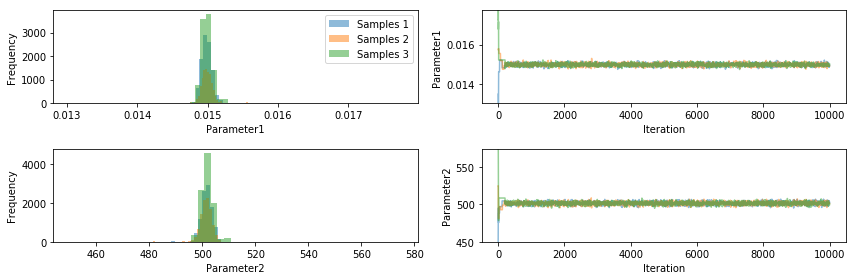

In [15]:
import pints.plot
pints.plot.trace(chains)
plt.show()

Based on this plot, it looks like the three chains become very similar after about 1000 iterations.
To be safe, we throw away the first 2000 samples and continue our analysis with the first chain.

In [16]:
chain = chains[0]
chain = chain[2000:]

We can also look for autocorrelation in the chains, using the [autocorrelation()](http://pints.readthedocs.io/en/latest/diagnostic_plots.html#pints.plot.autocorrelation) method. If everything went well, the samples in the chain should be relatively independent, so the autocorrelation should get quite low when the `lag` on the x-axis increases.

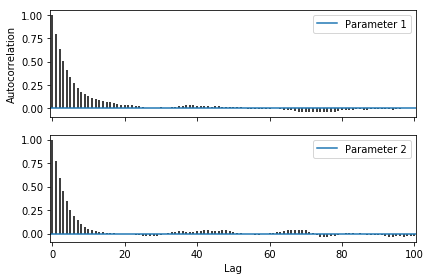

In [17]:
pints.plot.autocorrelation(chain)
plt.show()

Now we can inspect the inferred distribution by plotting histograms:

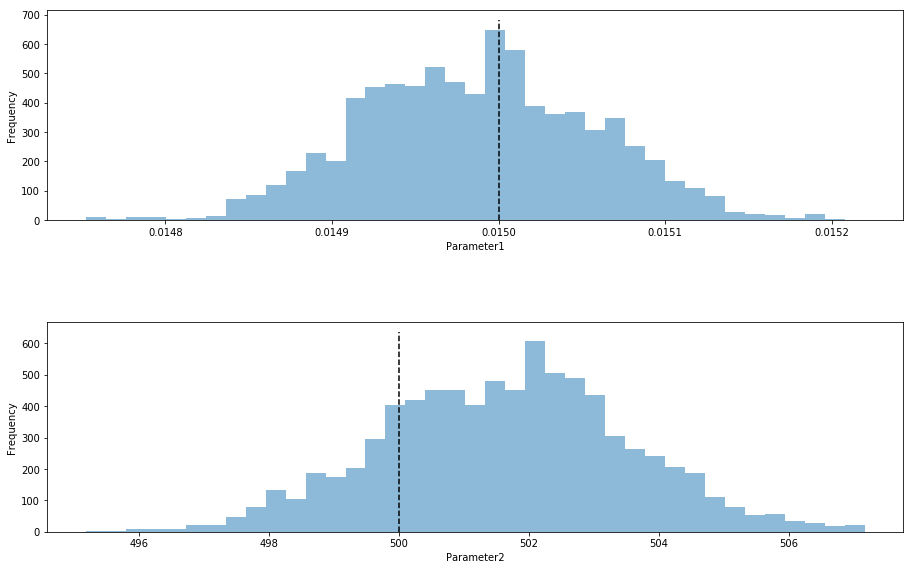

In [18]:
fig, axes = pints.plot.histogram([chain], ref_parameters=true_parameters)

# Show where the sample standard deviation of the generated noise is:
noise_sample_std = np.std(values - org_values)
#axes[-1].axvline(noise_sample_std, color='orange', label='Sample standard deviation of noise')
#axes[-1].legend()

fig.set_size_inches(14, 9)
plt.show()

Here we've analysed each parameter in isolation, but we can also look at correlations between parameters we found using the [pairwise()](http://pints.readthedocs.io/en/latest/diagnostic_plots.html#pints.plot.pairwise) plot.

To speed things up, we'll first apply some _thinning_ to the chain:

In [19]:
thinned_chain = chain[::10]

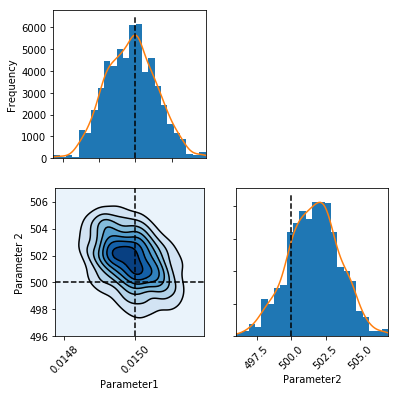

In [20]:
pints.plot.pairwise(thinned_chain, kde=True, ref_parameters=true_parameters)
plt.show()

Finally, we can look at the bit that really matters: The model predictions made from models with the parameters we found (a _posterior predictive check_). Thes can be plotted using the [series()](http://pints.readthedocs.io/en/latest/diagnostic_plots.html#pints.plot.series) method.

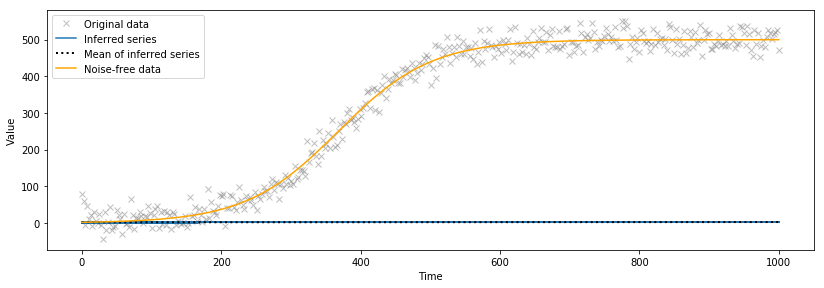

In [21]:
fig, axes = pints.plot.series(chain, problem)

# Customise the plot, and add the original, noise-free data
fig.set_size_inches(12,4.5)
plt.plot(times, org_values, c='orange', label='Noise-free data')
plt.legend()
plt.show()

-1835.9649822105055
[0.7448817  1.00398589]
-47172.5241914705


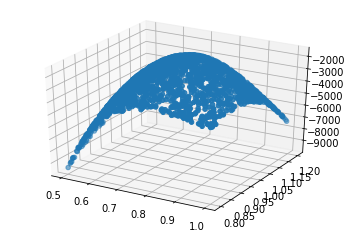

In [22]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

input_parameters = log_prior.sample(2000)
x = [p[0] for p in input_parameters]
y = [p[1] for p in input_parameters]
input_parameters[:5]

likelihoods = np.apply_along_axis(log_likelihood, 1, input_parameters)
likelihoods[:5]

print(max(likelihoods))
idx = list(likelihoods).index(max(likelihoods))
print(input_parameters[idx])
print(log_likelihood([0.015, 500]))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, list(likelihoods))
plt.show()

In [23]:
print(input_parameters[:5])

[[0.86361868 0.85818069]
 [0.56117768 1.15079221]
 [0.96836285 0.83798987]
 [0.68598703 1.19003873]
 [0.93181357 1.12045732]]


In [24]:
print(likelihoods[:5])

[-2758.82322268 -4294.53152166 -3511.42894891 -2992.35680084
 -4436.90932954]


In [25]:
[0.9*l for l in likelihoods[:5]]

[-2482.9409004146128,
 -3865.0783694975935,
 -3160.2860540169218,
 -2693.1211207589263,
 -3993.218396589518]

In [26]:
likelihoods = np.array([1.1*l for l in likelihoods])

In [27]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(input_parameters, likelihoods, test_size=0.3, random_state=0)
emu = pints.MultiLayerNN(problem, X_train, y_train, input_scaler=MinMaxScaler(), output_scaler=StandardScaler())
emu.set_parameters(layers=6, neurons=64, hidden_activation='relu', activation='linear', learning_rate=0.0001)
hist = emu.fit(epochs=500, batch_size=32, X_val=X_valid, y_val=y_valid, verbose=0)
emu.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                192       
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_3 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 82,753
Trainable params: 82,753
Non-trainable params: 0
_________________________________________________________________


In [28]:
emu([0.015, 500])

array([[-5460280.]], dtype=float32)

In [29]:
log_likelihood([0.015, 500])

-47172.5241914705

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error', 'rescaled_mae', 'rescaled_mse', 'val_rescaled_mae', 'val_rescaled_mse'])


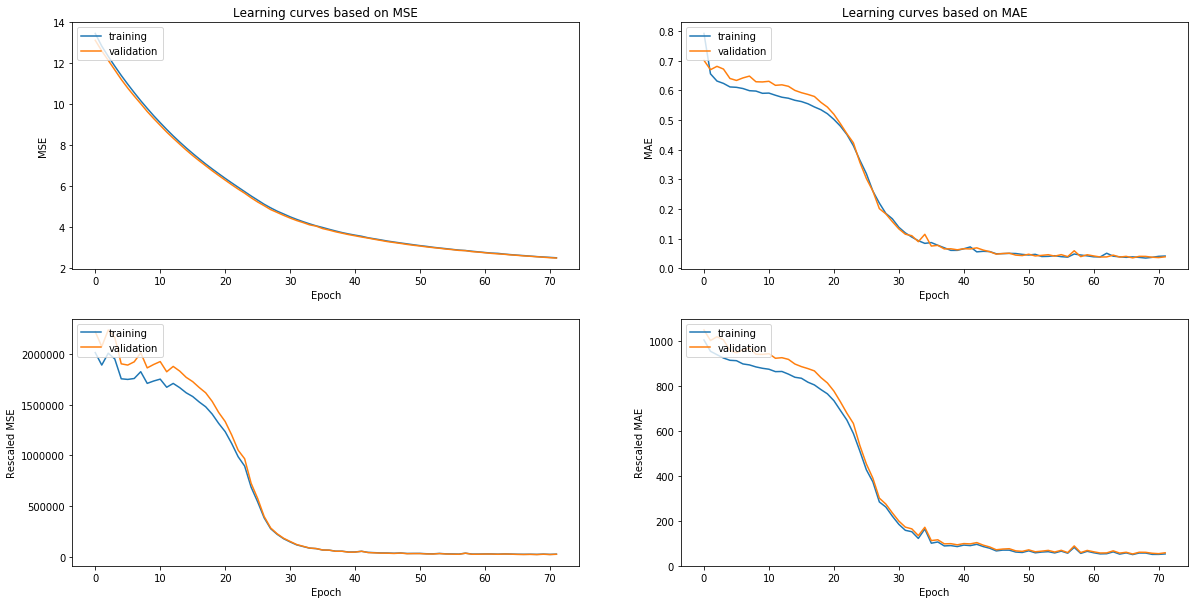

In [30]:
# summarize history for loss
print(hist.history.keys())
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20,10))                 
ax1.title.set_text('Learning curves based on MSE')
ax2.title.set_text('Learning curves based on MAE')

ax1.plot(hist.history['loss'])
ax1.plot(hist.history['val_loss'])
ax1.set_ylabel('MSE')
ax1.set_xlabel('Epoch')
ax1.legend(['training', 'validation'], loc='upper left')

ax2.plot(hist.history['mean_absolute_error'])
ax2.plot(hist.history['val_mean_absolute_error'])
ax2.set_ylabel('MAE')
ax2.set_xlabel('Epoch')
ax2.legend(['training', 'validation'], loc='upper left')

ax3.plot(hist.history['rescaled_mse'])
ax3.plot(hist.history['val_rescaled_mse'])
ax3.set_ylabel('Rescaled MSE')
ax3.set_xlabel('Epoch')
ax3.legend(['training', 'validation'], loc='upper left')

ax4.plot(hist.history['rescaled_mae'])
ax4.plot(hist.history['val_rescaled_mae'])
ax4.set_ylabel('Rescaled MAE')
ax4.set_xlabel('Epoch')
ax4.legend(['training', 'validation'], loc='upper left')

plt.show()

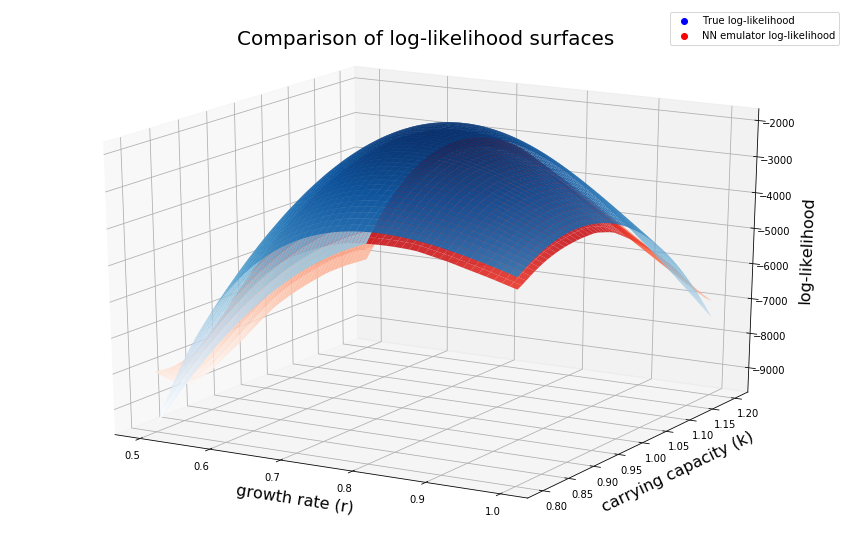

0.09148798628799809

In [31]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D 

test_splits = 50 # number of splits along each axis
r_grid, k_grid, test_data = pints.generate_grid(bounds.lower(), bounds.upper(), test_splits)
model_prediction = pints.predict_grid(log_likelihood, test_data)
emu_prediction = pints.predict_grid(emu, test_data)

figsize=(20,10)
angle=(20, 300)
alpha=0.9
fontsize=16
labelpad=10

title = "Comparison of log-likelihood surfaces"
x_label = "growth rate (r)"
y_label = "carrying capacity (k)"
z_label = "log-likelihood"


fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection='3d')
ax.plot_surface(r_grid, k_grid, model_prediction, cmap='Blues', edgecolor='none', alpha=alpha)
ax.plot_surface(r_grid, k_grid, emu_prediction, cmap='Reds', edgecolor='none', alpha=alpha)
#ax.view_init(60, 35)
ax.view_init(*angle)
#ax.set_title('surface')

plt.title(title, fontsize=fontsize*1.25)
ax.set_xlabel(x_label, fontsize=fontsize, labelpad=labelpad)
ax.set_ylabel(y_label, fontsize=fontsize, labelpad=labelpad)
ax.set_zlabel(z_label, fontsize=fontsize, labelpad=labelpad)

fake2Dline1 = mpl.lines.Line2D([0],[0], linestyle="none", c='blue', marker = 'o')
fake2Dline2 = mpl.lines.Line2D([0],[0], linestyle="none", c='red', marker = 'o')
ax.legend([fake2Dline1, fake2Dline2], ["True log-likelihood", "NN emulator log-likelihood"])

plt.show()
mape = np.mean(np.abs((model_prediction - emu_prediction) / model_prediction))
mape

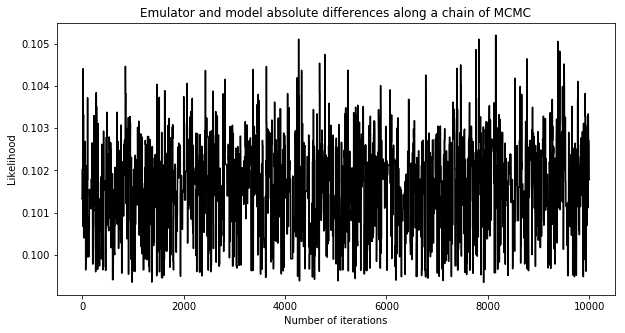

0.10178198009503972

In [32]:
emu_prediction = np.apply_along_axis(emu, 1, chain_rescaled).flatten()
model_prediction = np.apply_along_axis(log_likelihood, 1, chain_rescaled).flatten()
diffs = (np.abs((model_prediction - emu_prediction) / model_prediction))

iters = np.linspace(0, 10000, len(chain_rescaled))
plt.figure(figsize=(10, 5))
plt.title("Emulator and model absolute differences along a chain of MCMC")
plt.xlabel("Number of iterations")
plt.ylabel("Likelihood")
plt.plot(iters, diffs, color = "Black")
plt.show()

diffs[-1]

In [33]:
print(emu_prediction)

[-2021.3156 -2021.3156 -2021.3156 ... -2021.9235 -2021.9235 -2021.9235]


In [34]:
log_posterior_emu = pints.LogPosterior(emu, log_prior)

In [35]:
chains_emu = pints.mcmc_sample(log_posterior_emu, 3, xs)

Using Haario-Bardenet adaptive covariance MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0
1     6      0         0         0          0:00.0
2     9      0         0         0          0:00.0
3     12     0         0         0.25       0:00.0
20    63     0.143     0.143     0.19       0:00.0
40    123    0.0732    0.0732    0.122      0:00.1
60    183    0.0492    0.0492    0.0984     0:00.1
80    243    0.037     0.0494    0.0864     0:00.2
100   303    0.0396    0.0495    0.0693     0:00.2
120   363    0.0331    0.0496    0.0579     0:00.3
140   423    0.0355    0.0426    0.0496     0:00.4
160   483    0.0311    0.0373    0.0435     0:00.4
180   543    0.0331    0.0331    0.0387     0:00.5
Initial phase completed.
200   603    0.0299    0.0299    0.0348     0:00.5
220   663    0.0452    0.0498    0.0452     0:00.6
240   723    0.0954    0.0913    0.0871     0:00.6
260   783   

3100  9303   0.227991  0.223     0.224      0:08.7
3120  9363   0.228132  0.225     0.224      0:08.8
3140  9423   0.228     0.225     0.223      0:08.9
3160  9483   0.227     0.227     0.222      0:08.9
3180  9543   0.228     0.228     0.223      0:09.0
3200  9603   0.227     0.228     0.222      0:09.0
3220  9663   0.227     0.227     0.222      0:09.1
3240  9723   0.227     0.226     0.223      0:09.1
3260  9783   0.226     0.227     0.224      0:09.2
3280  9843   0.225541  0.227     0.224      0:09.3
3300  9903   0.226     0.228     0.224      0:09.3
3320  9963   0.226     0.227     0.225      0:09.4
3340  10023  0.226     0.225     0.224      0:09.4
3360  10083  0.226     0.226     0.225      0:09.5
3380  10143  0.226     0.226856  0.224      0:09.5
3400  10203  0.22611   0.226698  0.224      0:09.6
3420  10263  0.225     0.227     0.223      0:09.7
3440  10323  0.225     0.225     0.222      0:09.7
3460  10383  0.226     0.225     0.222      0:09.8
3480  10443  0.226     0.225   

6340  19023  0.229     0.23      0.226      0:18.7
6360  19083  0.229     0.23      0.226      0:18.8
6380  19143  0.23      0.229     0.226      0:18.9
6400  19203  0.229     0.23      0.226      0:18.9
6420  19263  0.229092  0.229     0.226      0:19.0
6440  19323  0.229157  0.229     0.226      0:19.1
6460  19383  0.229     0.229     0.226      0:19.1
6480  19443  0.229     0.229     0.227      0:19.2
6500  19503  0.228734  0.229     0.226      0:19.3
6520  19563  0.229     0.229     0.226      0:19.4
6540  19623  0.229     0.229     0.226      0:19.4
6560  19683  0.229     0.228     0.226      0:19.5
6580  19743  0.229     0.228     0.227      0:19.6
6600  19803  0.229     0.228     0.227      0:19.6
6620  19863  0.229     0.228     0.226      0:19.7
6640  19923  0.229     0.229     0.227      0:19.8
6660  19983  0.229395  0.229     0.226      0:19.8
6680  20043  0.229     0.228858  0.226      0:19.9
6700  20103  0.229     0.229     0.227      0:20.0
6720  20163  0.229     0.229   

9620  28863  0.232     0.231161  0.231      0:29.7
9640  28923  0.232     0.231     0.231      0:29.7
9660  28983  0.232     0.231     0.231239   0:29.8
9680  29043  0.232     0.231     0.231      0:29.8
9700  29103  0.232     0.231     0.231      0:29.9
9720  29163  0.232795  0.231     0.231      0:29.9
9740  29223  0.232625  0.231     0.231      0:30.0
9760  29283  0.232763  0.231     0.232      0:30.1
9780  29343  0.232696  0.231     0.231      0:30.1
9800  29403  0.233     0.231609  0.231507   0:30.2
9820  29463  0.232     0.232     0.231341   0:30.2
9840  29523  0.232     0.231887  0.231      0:30.3
9860  29583  0.232     0.232     0.231      0:30.3
9880  29643  0.232     0.232     0.231      0:30.4
9900  29703  0.231     0.232     0.231      0:30.5
9920  29763  0.231     0.232     0.231      0:30.5
9940  29823  0.231     0.232     0.231      0:30.6
9960  29883  0.231     0.231804  0.231      0:30.6
9980  29943  0.231     0.232     0.231      0:30.7
10000 30000  0.2308    0.232   

In [36]:
# Revert scaling
scaling_factors = [1/50, 500]
chains_emu_rescaled = np.copy(chains_emu)
chain_emu_rescaled = chains_emu_rescaled[0]
chain_emu_rescaled = chain_emu_rescaled[2000:]

chains_emu = np.array([[[s*f for s,f in zip(samples, scaling_factors)] for samples in chain] for chain in chains_emu])

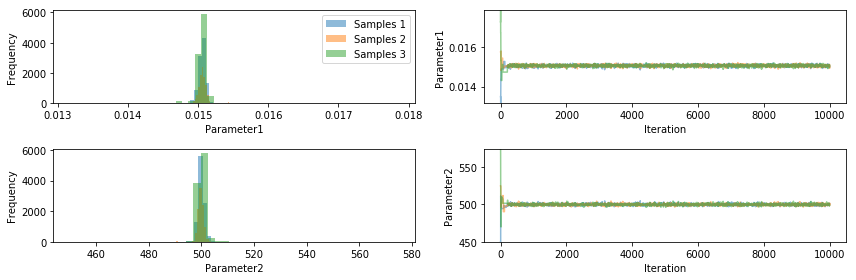

In [37]:
pints.plot.trace(chains_emu)
plt.show()

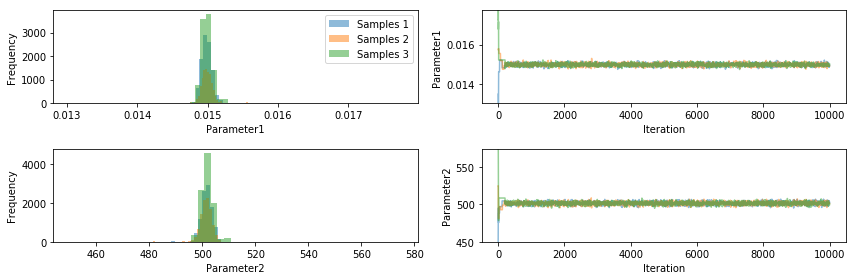

In [38]:
pints.plot.trace(chains)
plt.show()

In [39]:
chain_emu = chains_emu[0]
chain_emu = chain_emu[2000:]
chain = chains[0]
chain = chain[2000:]

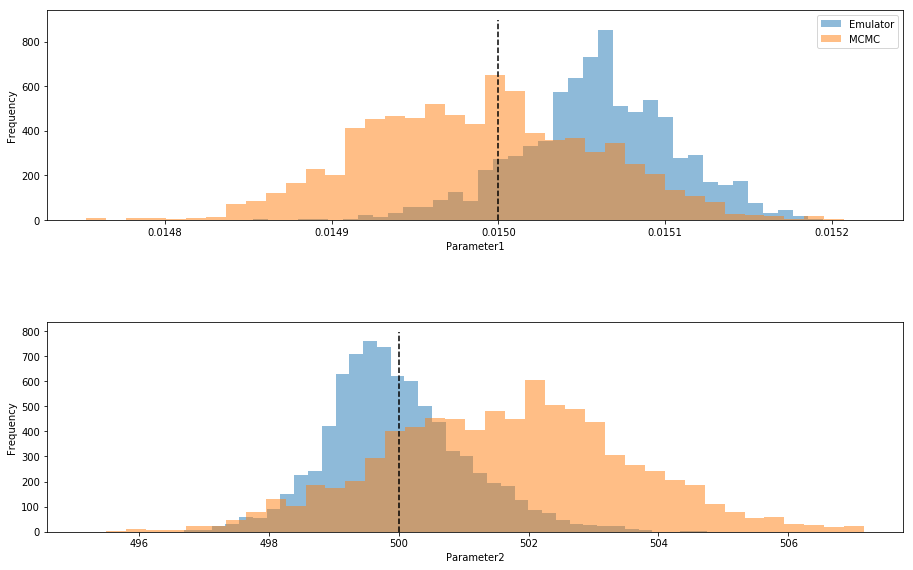

In [40]:
fig, axes = pints.plot.histogram([chain_emu, chain], ref_parameters=true_parameters, sample_names=["Emulator", "MCMC"])
fig.set_size_inches(14, 9)
plt.show()

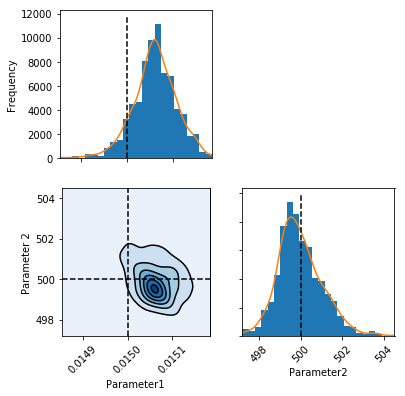

In [41]:
thinned_chain_emu = chain_emu[::10]
pints.plot.pairwise(thinned_chain_emu, kde=True, ref_parameters=true_parameters)
plt.show()

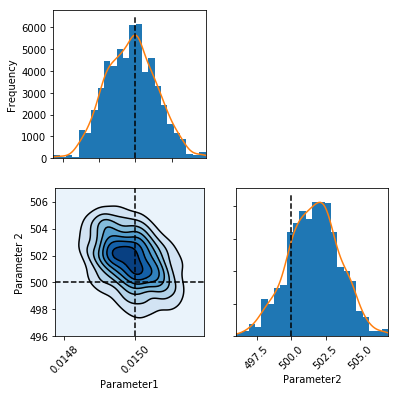

In [42]:
pints.plot.pairwise(thinned_chain, kde=True, ref_parameters=true_parameters)
plt.show()

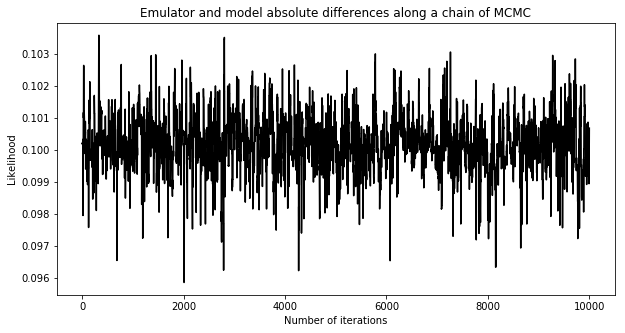

0.10067365251665542

In [43]:
emu_prediction = np.apply_along_axis(emu, 1, chain_emu_rescaled).flatten()
model_prediction = np.apply_along_axis(log_likelihood, 1, chain_rescaled).flatten()
diffs = (np.abs((model_prediction - emu_prediction) / model_prediction))

iters = np.linspace(0, 10000, len(chain_emu_rescaled))
plt.figure(figsize=(10, 5))
plt.title("Emulator and model absolute differences along a chain of MCMC")
plt.xlabel("Number of iterations")
plt.ylabel("Likelihood")
plt.plot(iters, diffs, color = "Black")
plt.show()

diffs[-1]

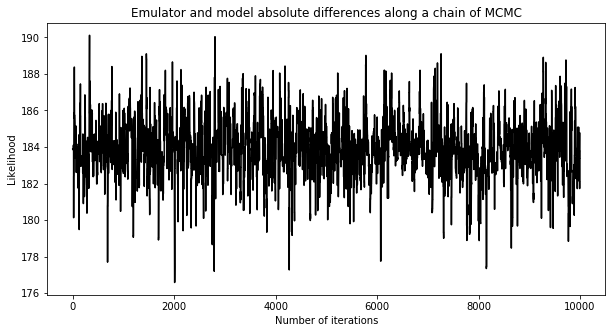

184.75018079570577

In [44]:
emu_prediction = np.apply_along_axis(emu, 1, chain_emu_rescaled).flatten()
model_prediction = np.apply_along_axis(log_likelihood, 1, chain_rescaled).flatten()
diffs = (model_prediction - emu_prediction)

iters = np.linspace(0, 10000, len(chain_emu_rescaled))
plt.figure(figsize=(10, 5))
plt.title("Emulator and model absolute differences along a chain of MCMC")
plt.xlabel("Number of iterations")
plt.ylabel("Likelihood")
plt.plot(iters, diffs, color = "Black")
plt.show()

diffs[-1]

In [45]:
chain_emu

array([[1.50815313e-02, 5.00178522e+02],
       [1.50815313e-02, 5.00178522e+02],
       [1.50815313e-02, 5.00178522e+02],
       ...,
       [1.50597734e-02, 4.99684829e+02],
       [1.49975299e-02, 5.01128008e+02],
       [1.49975299e-02, 5.01128008e+02]])

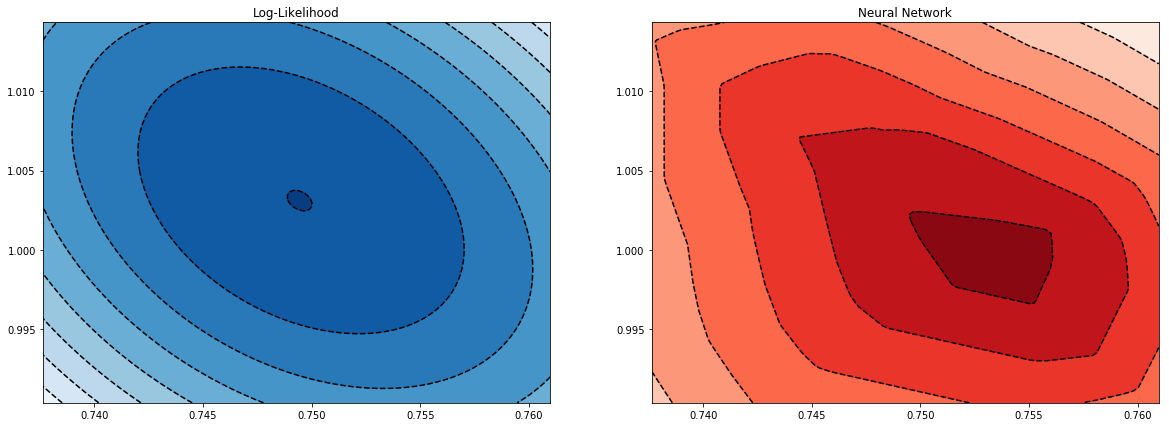

In [46]:
# Create grid of parameters
x = [p[0] for p in chain_rescaled]
y = [p[1] for p in chain_rescaled]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood')
ax2.title.set_text('Neural Network')
ax1.contourf(xx, yy, ll, cmap='Blues', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='k')
ax2.contourf(xx, yy, ll_emu, cmap='Reds', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='k')
plt.show()

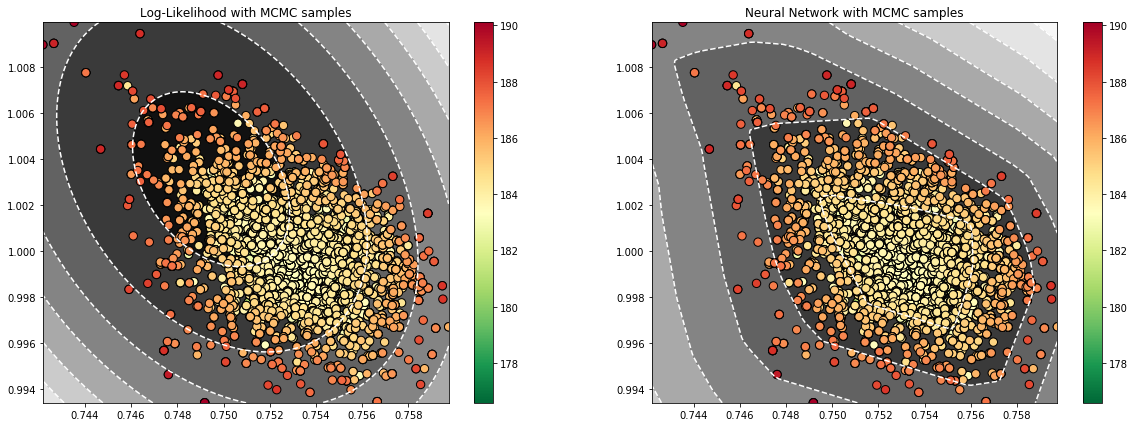

In [47]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood with MCMC samples')
ax2.title.set_text('Neural Network with MCMC samples')                                                                  

# Create grid of parameters
x = [p[0] for p in chain_emu_rescaled]
y = [p[1] for p in chain_emu_rescaled]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

# Sort according to differences in log-likelihood
idx = diffs.argsort()
x_sorted = np.array(x)[idx]
y_sorted = np.array(y)[idx]
diffs_sorted = diffs[idx]

# Add contour lines of log-likelihood
ax1.contourf(xx, yy, ll, cmap='Greys', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='w')

# Plot chain_emu    
ax1.set_xlim([xmin, xmax])                                                                           
ax1.set_ylim([ymin, ymax])
im1 = ax1.scatter(x_sorted, y_sorted, c=diffs_sorted, s=70, edgecolor='k', cmap="RdYlGn_r")

# Add contour lines of emulated likelihood
ax2.contourf(xx, yy, ll_emu, cmap='Greys', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='w')

# Plot chain_emu    
ax2.set_xlim([xmin, xmax])                                                                           
ax2.set_ylim([ymin, ymax])
im2 = ax2.scatter(x_sorted, y_sorted, c=diffs_sorted, s=70, edgecolor='k', cmap="RdYlGn_r")

fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)
plt.show()

Running...
Using Emulated Metropolis MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0
1     6      0         0         0          0:00.0
2     9      0         0         0.333      0:00.0
3     12     0         0         0.5        0:00.0
20    63     0.143     0         0.333      0:00.1
40    123    0.0976    0.0488    0.293      0:00.1
60    183    0.0984    0.0984    0.23       0:00.2
80    243    0.0741    0.21      0.185      0:00.2
100   303    0.0693    0.238     0.158      0:00.3
120   363    0.0579    0.231405  0.14       0:00.4
140   423    0.0496    0.22      0.128      0:00.4
160   483    0.0559    0.205     0.112      0:00.5
180   543    0.0497    0.198895  0.0994     0:00.5
200   603    0.0448    0.194     0.0896     0:00.6
220   663    0.0498    0.19      0.0814     0:00.7
240   723    0.0456    0.191     0.0747     0:00.7
260   783    0.0421    0.192     0.069    

3100  9303   0.134     0.246     0.0129     0:09.5
3120  9363   0.135     0.247     0.0128     0:09.6
3140  9423   0.136     0.247     0.0134     0:09.7
3160  9483   0.136982  0.247     0.0133     0:09.7
3180  9543   0.138     0.247     0.0132     0:09.8
3200  9603   0.139     0.246     0.0134     0:09.9
3220  9663   0.14      0.245     0.0133     0:09.9
3240  9723   0.14      0.245     0.0136     0:10.0
3260  9783   0.141     0.246     0.0135     0:10.0
3280  9843   0.143     0.247     0.0134     0:10.1
3300  9903   0.144     0.246289  0.0133     0:10.2
3320  9963   0.146     0.246     0.0132     0:10.3
3340  10023  0.148     0.246     0.0132     0:10.3
3360  10083  0.148     0.246     0.0131     0:10.4
3380  10143  0.148     0.246081  0.013      0:10.5
3400  10203  0.149     0.246     0.0129     0:10.5
3420  10263  0.15      0.248     0.0132     0:10.6
3440  10323  0.151     0.247     0.0131     0:10.7
3460  10383  0.152     0.246     0.013      0:10.7
3480  10443  0.152     0.247   

6360  19083  0.204     0.249     0.0101     0:19.5
6380  19143  0.204     0.249     0.01       0:19.5
6400  19203  0.204     0.249     0.0102     0:19.6
6420  19263  0.204     0.249     0.0101     0:19.6
6440  19323  0.204     0.249     0.0101     0:19.7
6460  19383  0.204148  0.248     0.0101     0:19.8
6480  19443  0.204     0.248     0.01       0:19.8
6500  19503  0.204     0.248731  0.01       0:19.9
6520  19563  0.204     0.249     0.00997    0:19.9
6540  19623  0.204403  0.249     0.00994    0:20.0
6560  19683  0.205     0.249     0.00991    0:20.1
6580  19743  0.205288  0.248     0.00988    0:20.1
6600  19803  0.206     0.249     0.00985    0:20.2
6620  19863  0.205407  0.248     0.00997    0:20.2
6640  19923  0.206     0.249     0.00994    0:20.3
6660  19983  0.205825  0.249     0.00991    0:20.3
6680  20043  0.206     0.249     0.01       0:20.4
6700  20103  0.206     0.249515  0.01       0:20.5
6720  20163  0.205773  0.25      0.00997    0:20.5
6740  20223  0.206     0.25    

9580  28743  0.215     0.252     0.00887    0:29.0
9600  28803  0.215     0.252     0.00885    0:29.1
9620  28863  0.215674  0.252     0.00894    0:29.1
9640  28923  0.215849  0.252     0.00892    0:29.2
9660  28983  0.216     0.252     0.0089     0:29.3
9680  29043  0.217     0.252     0.00888    0:29.3
9700  29103  0.217     0.252139  0.00897    0:29.4
9720  29163  0.217     0.252     0.00895    0:29.4
9740  29223  0.218     0.252     0.00893    0:29.5
9760  29283  0.217     0.252     0.00891    0:29.6
9780  29343  0.217     0.252     0.00889    0:29.6
9800  29403  0.217     0.253     0.00888    0:29.7
9820  29463  0.218     0.252     0.00886    0:29.7
9840  29523  0.217356  0.252     0.00884    0:29.8
9860  29583  0.217625  0.253     0.00892    0:29.9
9880  29643  0.218     0.252     0.00891    0:29.9
9900  29703  0.217     0.253     0.00889    0:30.0
9920  29763  0.218     0.253     0.00887    0:30.1
9940  29823  0.218     0.253     0.00885    0:30.1
9960  29883  0.218     0.253589

12820 38463  0.23      0.252     0.00835    0:38.4
12840 38523  0.23      0.252     0.00841    0:38.4
12860 38583  0.23      0.252     0.0084     0:38.5
12880 38643  0.230184  0.252     0.00838    0:38.5
12900 38703  0.23      0.252     0.00837    0:38.6
12920 38763  0.23      0.252     0.00836    0:38.6
12940 38823  0.23      0.251758  0.00835    0:38.7
12960 38883  0.23      0.252     0.00833    0:38.7
12980 38943  0.23      0.252     0.00832    0:38.8
13000 39003  0.23029   0.252     0.00831    0:38.9
13020 39063  0.23      0.25144   0.00829    0:38.9
13040 39123  0.23      0.251     0.00828    0:39.0
13060 39183  0.23      0.251     0.00827    0:39.0
13080 39243  0.23      0.252     0.00826    0:39.0
13100 39303  0.23      0.252     0.00832    0:39.1
13120 39363  0.231     0.252     0.00831    0:39.1
13140 39423  0.23      0.252     0.00829    0:39.2
13160 39483  0.23      0.252     0.00828    0:39.3
13180 39543  0.231     0.252     0.00827    0:39.3
13200 39603  0.231     0.252   

16100 48303  0.235     0.254     0.00801    0:47.1
16120 48363  0.235     0.254     0.008      0:47.1
16140 48423  0.234     0.254     0.00799    0:47.2
16160 48483  0.234     0.254     0.00798    0:47.2
16180 48543  0.234     0.254     0.00797    0:47.3
16200 48603  0.234     0.254     0.00796    0:47.4
16220 48663  0.234     0.254     0.00795    0:47.5
16240 48723  0.234     0.254     0.00794    0:47.6
16260 48783  0.234     0.254     0.00799    0:47.7
16280 48843  0.234     0.254     0.00805    0:47.7
16300 48903  0.235     0.254     0.0081     0:47.8
16320 48963  0.235     0.254     0.00809    0:47.9
16340 49023  0.234747  0.254     0.00808    0:47.9
16360 49083  0.235     0.254     0.00807    0:48.0
16380 49143  0.235     0.254     0.00806    0:48.1
16400 49203  0.235     0.254     0.00805    0:48.1
16420 49263  0.235     0.254     0.00804    0:48.2
16440 49323  0.235     0.253     0.00803    0:48.3
16460 49383  0.235     0.253569  0.00802    0:48.3
16480 49443  0.235     0.253504

19340 58023  0.238     0.254     0.00765    0:56.5
19360 58083  0.238     0.254     0.00764    0:56.5
19380 58143  0.238     0.254     0.00764    0:56.6
19400 58203  0.238     0.254     0.00763    0:56.6
19420 58263  0.238     0.254     0.00762    0:56.7
19440 58323  0.238     0.254     0.00766    0:56.7
19460 58383  0.238     0.254     0.00766    0:56.8
19480 58443  0.238     0.254     0.0077     0:56.8
19500 58503  0.238     0.254     0.00774    0:56.9
19520 58563  0.238205  0.255     0.00774    0:57.0
19540 58623  0.238     0.255     0.00773    0:57.0
19560 58683  0.238     0.255     0.00772    0:57.1
19580 58743  0.238     0.255     0.00771    0:57.1
19600 58803  0.238     0.255     0.0077     0:57.2
19620 58863  0.238     0.255     0.0077     0:57.2
19640 58923  0.238     0.255     0.007688   0:57.3
19660 58983  0.238289  0.255     0.00768    0:57.3
19680 59043  0.238     0.255     0.00767    0:57.4
19700 59103  0.238     0.255     0.00766    0:57.4
19720 59163  0.238     0.255   

22620 67863  0.239954  0.258     0.00769    1:05.7
22640 67923  0.24      0.258     0.00769    1:05.8
22660 67983  0.24006   0.258     0.00768    1:05.9
22680 68043  0.240201  0.258     0.00767    1:05.9
22700 68103  0.24      0.258     0.00766    1:06.0
22720 68163  0.24      0.258     0.00766    1:06.0
22740 68223  0.24      0.258     0.00765    1:06.1
22760 68283  0.240587  0.258     0.00764    1:06.1
22780 68343  0.241     0.257     0.00764    1:06.2
22800 68403  0.241     0.257     0.00763    1:06.3
22820 68463  0.240787  0.257     0.00762    1:06.3
22840 68523  0.241     0.257     0.00762    1:06.4
22860 68583  0.241     0.258     0.00761    1:06.4
22880 68643  0.241     0.257     0.0076     1:06.5
22900 68703  0.241     0.257     0.0076     1:06.5
22920 68763  0.241     0.257275  0.00759    1:06.6
22940 68823  0.241     0.257     0.00758    1:06.6
22960 68883  0.241     0.257     0.00758    1:06.7
22980 68943  0.241     0.257     0.00757    1:06.7
23000 69003  0.241     0.258   

25840 77523  0.242     0.256569  0.0077     1:14.7
25860 77583  0.242218  0.257     0.00769    1:14.7
25880 77643  0.242     0.256443  0.00769    1:14.8
25900 77703  0.242     0.256438  0.00768    1:14.8
25920 77763  0.243     0.256     0.00768    1:14.9
25940 77823  0.242     0.256     0.00767    1:14.9
25960 77883  0.242325  0.256269  0.00767    1:15.0
25980 77943  0.242     0.256     0.00766    1:15.1
26000 78003  0.242     0.256     0.00765    1:15.1
26020 78063  0.242     0.256     0.00765    1:15.2
26040 78123  0.242     0.256     0.00764    1:15.2
26060 78183  0.242201  0.256     0.00764    1:15.3
26080 78243  0.242     0.256     0.00763    1:15.3
26100 78303  0.242     0.256     0.00762    1:15.4
26120 78363  0.242     0.256     0.00762    1:15.4
26140 78423  0.242     0.256     0.00765    1:15.5
26160 78483  0.242     0.256374  0.00764    1:15.5
26180 78543  0.242     0.256     0.00764    1:15.6
26200 78603  0.242319  0.256     0.00763    1:15.7
26220 78663  0.242     0.256   

29120 87363  0.242     0.256     0.00817    1:23.6
29140 87423  0.243     0.256134  0.0082     1:23.7
29160 87483  0.243     0.256     0.0082     1:23.7
29180 87543  0.243     0.256     0.00819    1:23.8
29200 87603  0.243     0.256     0.00822    1:23.8
29220 87663  0.243     0.256     0.00821    1:23.9
29240 87723  0.243     0.256     0.00821    1:23.9
29260 87783  0.243     0.256     0.0082     1:24.0
29280 87843  0.243     0.256     0.0082     1:24.1
29300 87903  0.242961  0.256     0.00819    1:24.1
29320 87963  0.243     0.256     0.00819    1:24.2
29340 88023  0.243     0.256024  0.00821    1:24.2
29360 88083  0.243     0.256     0.00821    1:24.3
29380 88143  0.243     0.256     0.0082     1:24.3
29400 88203  0.243053  0.256     0.00823    1:24.4
29420 88263  0.243     0.256     0.00823    1:24.4
29440 88323  0.243     0.256     0.00825    1:24.5
29460 88383  0.243     0.256     0.00825    1:24.5
29480 88443  0.243     0.256     0.00824    1:24.6
29500 88503  0.243     0.255754

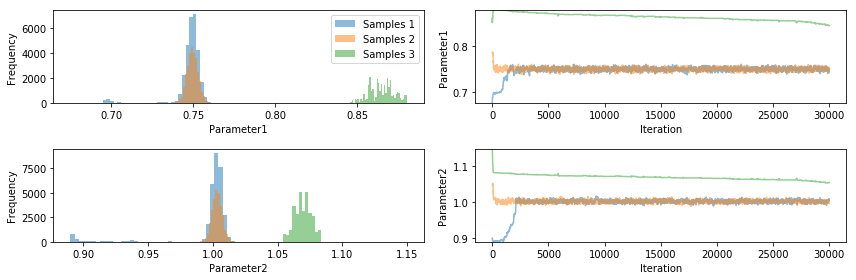

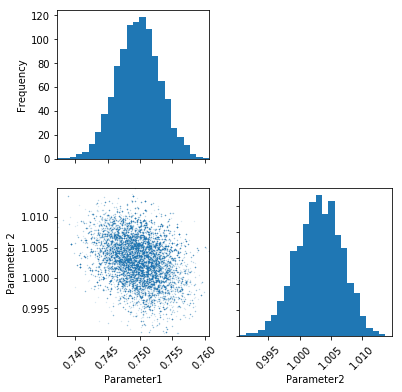

In [48]:
# Choose starting points for 3 mcmc chains
x0s = [
    np.array(start_parameters) * 0.9,
    np.array(start_parameters) * 1.05, #1.1
    np.array(start_parameters) * 1.15,
]
# Choose a covariance matrix for the proposal step
#sigma0 = [0.01, 0.01] #np.abs(true_parameters) * 5e-3
#sigma0 = [0.1*0.75, 0.1] #np.abs(true_parameters) * 5e-3
sigma0 = [[ 1.01547594e-05, -2.58358260e-06], [-2.58358260e-06,  1.22093040e-05]]

# Create mcmc routine
mcmc = pints.MCMCController(log_posterior_emu, 3, x0s, sigma0=sigma0, method=pints.EmulatedMetropolisMCMC, f=log_posterior)

# Add stopping criterion
mcmc.set_max_iterations(30000)

# Disable logging mode
#mcmc.set_log_to_screen(False)

# Run!
print('Running...')
emulated_chains = mcmc.run()
print('Done!')

# Show traces and histograms
pints.plot.trace(emulated_chains)

# Discard warm up
emulated_chains_thinned = emulated_chains[:, 10000:, :]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(emulated_chains_thinned))

# Look at distribution in chain 0
pints.plot.pairwise(emulated_chains_thinned[0])

# Show graphs
plt.show()

Running...
Using Metropolis random walk MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0
1     6      0         0         0.5        0:00.0
2     9      0.333     0.333     0.667      0:00.0
3     12     0.25      0.25      0.75       0:00.0
20    63     0.429     0.571     0.619      0:00.0
40    123    0.488     0.561     0.512      0:00.0
60    183    0.475     0.59      0.475      0:00.1
80    243    0.494     0.519     0.457      0:00.1
100   303    0.495     0.554     0.446      0:00.1
120   363    0.537     0.562     0.438      0:00.1
140   423    0.539     0.567     0.461      0:00.1
160   483    0.54      0.602     0.466      0:00.1
180   543    0.541     0.613     0.459      0:00.1
200   603    0.537     0.612     0.463      0:00.2
220   663    0.543     0.597     0.471      0:00.2
240   723    0.548     0.585     0.485      0:00.2
260   783    0.563     0.582     0.494 

3220  9663   0.555728  0.551     0.568      0:02.7
3240  9723   0.557     0.55      0.569      0:02.7
3260  9783   0.557     0.551     0.568      0:02.7
3280  9843   0.558     0.551     0.567      0:02.7
3300  9903   0.558     0.553     0.566495   0:02.8
3320  9963   0.558     0.552     0.567299   0:02.8
3340  10023  0.557     0.553     0.567      0:02.8
3360  10083  0.556382  0.552     0.567      0:02.8
3380  10143  0.556     0.553     0.567      0:02.8
3400  10203  0.556     0.552     0.568      0:02.9
3420  10263  0.555     0.55247   0.569      0:02.9
3440  10323  0.554     0.552     0.568      0:02.9
3460  10383  0.554     0.552     0.566      0:02.9
3480  10443  0.555     0.552     0.567      0:02.9
3500  10503  0.555     0.553     0.568      0:02.9
3520  10563  0.554672  0.552     0.569      0:03.0
3540  10623  0.554     0.552     0.569      0:03.0
3560  10683  0.554     0.553     0.569      0:03.0
3580  10743  0.555     0.554     0.568      0:03.0
3600  10803  0.555     0.554   

6680  20043  0.566     0.565     0.563      0:05.8
6700  20103  0.565     0.564     0.564      0:05.8
6720  20163  0.565     0.564     0.564      0:05.8
6740  20223  0.564753  0.564     0.563      0:05.8
6760  20283  0.565     0.564     0.563      0:05.9
6780  20343  0.564     0.563     0.563      0:05.9
6800  20403  0.564     0.563     0.563      0:05.9
6820  20463  0.564     0.564     0.563      0:05.9
6840  20523  0.564     0.563     0.564      0:05.9
6860  20583  0.564     0.563912  0.563      0:05.9
6880  20643  0.563     0.564     0.564      0:06.0
6900  20703  0.564     0.564266  0.564      0:06.0
6920  20763  0.563     0.565     0.564      0:06.0
6940  20823  0.563     0.564616  0.564      0:06.0
6960  20883  0.563     0.564     0.564      0:06.0
6980  20943  0.563     0.564     0.564      0:06.1
7000  21003  0.563     0.564     0.563      0:06.1
7020  21063  0.562     0.565     0.563      0:06.1
7040  21123  0.562     0.565     0.563      0:06.1
7060  21183  0.562     0.565   

10080 30243  0.558     0.562     0.559      0:08.7
10100 30303  0.558     0.562     0.56       0:08.7
10120 30363  0.559     0.562     0.559      0:08.7
10140 30423  0.559     0.562     0.559      0:08.7
10160 30483  0.558     0.562     0.559      0:08.7
10180 30543  0.558     0.562     0.559      0:08.8
10200 30603  0.558     0.562     0.559      0:08.8
10220 30663  0.558     0.563     0.559      0:08.8
10240 30723  0.558051  0.563     0.559      0:08.8
10260 30783  0.558     0.562     0.559      0:08.8
10280 30843  0.558     0.562     0.559      0:08.8
10300 30903  0.558     0.563     0.559      0:08.9
10320 30963  0.558     0.562     0.56       0:08.9
10340 31023  0.558     0.562228  0.56       0:08.9
10360 31083  0.558     0.562     0.56       0:08.9
10380 31143  0.558     0.562     0.56       0:08.9
10400 31203  0.558     0.562     0.55985    0:08.9
10420 31263  0.558     0.562     0.56       0:09.0
10440 31323  0.558     0.562     0.56       0:09.0
10460 31383  0.558742  0.561801

13540 40623  0.56      0.567     0.559      0:11.6
13560 40683  0.56      0.567     0.559472   0:11.6
13580 40743  0.56      0.567     0.56       0:11.6
13600 40803  0.56      0.567     0.56       0:11.6
13620 40863  0.56      0.567     0.56       0:11.6
13640 40923  0.56      0.566674  0.56       0:11.6
13660 40983  0.56      0.56643   0.56       0:11.6
13680 41043  0.56      0.567     0.56       0:11.7
13700 41103  0.56      0.567     0.56       0:11.7
13720 41163  0.56      0.567     0.56       0:11.7
13740 41223  0.56      0.566771  0.559      0:11.7
13760 41283  0.560061  0.567     0.559189   0:11.7
13780 41343  0.56      0.566     0.559      0:11.7
13800 41403  0.56      0.566     0.559      0:11.8
13820 41463  0.56      0.566     0.56       0:11.8
13840 41523  0.56      0.566     0.56       0:11.8
13860 41583  0.56      0.566     0.56       0:11.8
13880 41643  0.56      0.566     0.559      0:11.8
13900 41703  0.559672  0.566     0.559      0:11.8
13920 41763  0.56      0.566   

16760 50283  0.562     0.565539  0.562      0:14.2
16780 50343  0.562     0.566     0.562      0:14.2
16800 50403  0.562     0.565     0.562      0:14.2
16820 50463  0.562     0.565     0.562095   0:14.3
16840 50523  0.56214   0.565     0.562      0:14.3
16860 50583  0.562     0.565091  0.562      0:14.3
16880 50643  0.562     0.565     0.562      0:14.3
16900 50703  0.562     0.565     0.562      0:14.3
16920 50763  0.562     0.565333  0.562      0:14.3
16940 50823  0.562     0.565492  0.562      0:14.4
16960 50883  0.561     0.565     0.562      0:14.4
16980 50943  0.561451  0.566     0.562      0:14.4
17000 51003  0.561     0.565     0.562      0:14.4
17020 51063  0.561     0.565     0.562      0:14.4
17040 51123  0.561176  0.565     0.562      0:14.4
17060 51183  0.561     0.565     0.562      0:14.5
17080 51243  0.561384  0.565     0.561384   0:14.5
17100 51303  0.561     0.565     0.561      0:14.5
17120 51363  0.561     0.565     0.561      0:14.5
17140 51423  0.561     0.565   

20000 60003  0.560622  0.566     0.558      0:16.9
20020 60063  0.561     0.566     0.558      0:16.9
20040 60123  0.561     0.566     0.558      0:16.9
20060 60183  0.561     0.566     0.559      0:16.9
20080 60243  0.561     0.566     0.559      0:16.9
20100 60303  0.561     0.566     0.559      0:16.9
20120 60363  0.561     0.566     0.559      0:16.9
20140 60423  0.561     0.566     0.559      0:17.0
20160 60483  0.561     0.566     0.559      0:17.0
20180 60543  0.561     0.566     0.559338   0:17.0
20200 60603  0.561     0.566     0.559      0:17.0
20220 60663  0.561     0.566     0.559      0:17.0
20240 60723  0.56      0.566     0.559      0:17.0
20260 60783  0.56      0.566     0.559      0:17.1
20280 60843  0.560426  0.566     0.559      0:17.1
20300 60903  0.56      0.566     0.559135   0:17.1
20320 60963  0.56      0.566     0.559      0:17.1
20340 61023  0.56      0.566     0.559      0:17.1
20360 61083  0.56      0.566     0.559      0:17.1
20380 61143  0.56      0.566   

23380 70143  0.562     0.566     0.558      0:19.5
23400 70203  0.562     0.566     0.558      0:19.5
23420 70263  0.562     0.566     0.558      0:19.5
23440 70323  0.562     0.566     0.558338   0:19.6
23460 70383  0.562     0.566     0.558203   0:19.6
23480 70443  0.562     0.566     0.558      0:19.6
23500 70503  0.562     0.567     0.558      0:19.6
23520 70563  0.562     0.567     0.558      0:19.6
23540 70623  0.562     0.567     0.558      0:19.6
23560 70683  0.562     0.567     0.558      0:19.7
23580 70743  0.562     0.567     0.558      0:19.7
23600 70803  0.562     0.567     0.558578   0:19.7
23620 70863  0.562     0.567     0.559      0:19.7
23640 70923  0.562     0.567     0.559      0:19.7
23660 70983  0.562     0.567     0.559      0:19.7
23680 71043  0.562     0.567     0.559      0:19.7
23700 71103  0.561875  0.567     0.559      0:19.8
23720 71163  0.561865  0.567     0.559      0:19.8
23740 71223  0.562     0.567     0.558738   0:19.8
23760 71283  0.561803  0.567   

26700 80103  0.564     0.567357  0.561      0:22.1
26720 80163  0.564425  0.567     0.56       0:22.1
26740 80223  0.564     0.567     0.56       0:22.1
26760 80283  0.564     0.567     0.560293   0:22.2
26780 80343  0.564     0.567     0.56036    0:22.2
26800 80403  0.564     0.567     0.560203   0:22.2
26820 80463  0.564     0.567     0.56       0:22.2
26840 80523  0.564     0.567341  0.56       0:22.2
26860 80583  0.564     0.568     0.56       0:22.2
26880 80643  0.564     0.568     0.56       0:22.3
26900 80703  0.564     0.568     0.56       0:22.3
26920 80763  0.564     0.567     0.56       0:22.3
26940 80823  0.564     0.567     0.56       0:22.3
26960 80883  0.564     0.567     0.561      0:22.3
26980 80943  0.564     0.567     0.56       0:22.3
27000 81003  0.564     0.567     0.56       0:22.4
27020 81063  0.564     0.567     0.560564   0:22.4
27040 81123  0.564     0.567     0.561      0:22.4
27060 81183  0.564     0.567     0.561      0:22.4
27080 81243  0.564344  0.567   

R-hat:
[1.000477770789624, 1.0000619624168055]


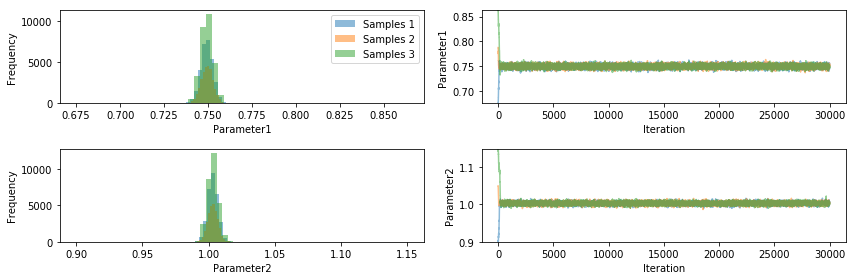

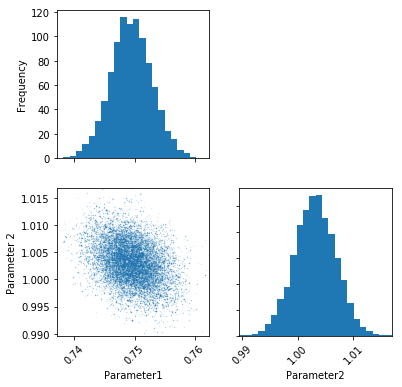

In [49]:
# Choose starting points for 3 mcmc chains
x0s = [
    np.array(start_parameters) * 0.9,
    np.array(start_parameters) * 1.05, #1.1
    np.array(start_parameters) * 1.15,
]
# Choose a covariance matrix for the proposal step
#sigma0 = [0.01, 0.01] #np.abs(true_parameters) * 5e-5
sigma0 = [[ 1.01547594e-05, -2.58358260e-06], [-2.58358260e-06,  1.22093040e-05]]

# Create mcmc routine
mcmc = pints.MCMCController(log_posterior, 3, x0s, sigma0=sigma0, method=pints.MetropolisRandomWalkMCMC)

# Add stopping criterion
mcmc.set_max_iterations(30000)

# Disable logging mode
#mcmc.set_log_to_screen(False)

# Run!
print('Running...')
metropolis_chains = mcmc.run()
print('Done!')

# Show traces and histograms
pints.plot.trace(metropolis_chains)

# Discard warm up
metropolis_chains_thinned = metropolis_chains[:, 10000:, :]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(metropolis_chains_thinned))

# Look at distribution in chain 0
pints.plot.pairwise(metropolis_chains_thinned[0])

# Show graphs
plt.show()

Running...
Using Haario-Bardenet adaptive covariance MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0
1     6      0         0         0          0:00.0
2     9      0         0         0.333      0:00.0
3     12     0.25      0         0.25       0:00.0
20    63     0.238     0.0952    0.238      0:00.0
40    123    0.171     0.0732    0.122      0:00.0
60    183    0.131     0.0656    0.082      0:00.0
80    243    0.111     0.0494    0.0617     0:00.1
100   303    0.099     0.0495    0.0495     0:00.1
120   363    0.0826    0.0496    0.0413     0:00.1
140   423    0.0709    0.0426    0.0426     0:00.1
160   483    0.0621    0.0373    0.0373     0:00.1
180   543    0.0552    0.0331    0.0331     0:00.1
Initial phase completed.
200   603    0.0498    0.0348    0.0299     0:00.2
220   663    0.0724    0.0543    0.0407     0:00.2
240   723    0.108     0.104     0.083      0:00.2
2

3260  9783   0.228     0.226     0.228      0:02.8
3280  9843   0.229     0.225     0.228      0:02.9
3300  9903   0.229     0.224     0.228      0:02.9
3320  9963   0.23      0.224     0.228      0:02.9
3340  10023  0.23      0.224     0.227      0:02.9
3360  10083  0.231     0.225     0.229      0:02.9
3380  10143  0.232     0.226     0.229      0:02.9
3400  10203  0.232     0.226404  0.23       0:03.0
3420  10263  0.231     0.226     0.23       0:03.0
3440  10323  0.231     0.226     0.23       0:03.0
3460  10383  0.231     0.225     0.23       0:03.0
3480  10443  0.23      0.225     0.23       0:03.0
3500  10503  0.231     0.226     0.23       0:03.0
3520  10563  0.23      0.226     0.229      0:03.1
3540  10623  0.231     0.226     0.229      0:03.1
3560  10683  0.231     0.227     0.229      0:03.1
3580  10743  0.231     0.227     0.229      0:03.1
3600  10803  0.23      0.227     0.229      0:03.1
3620  10863  0.229     0.226     0.228      0:03.1
3640  10923  0.229     0.226   

6580  19743  0.229     0.225     0.23       0:06.3
6600  19803  0.228     0.225     0.23       0:06.3
6620  19863  0.228     0.225     0.23       0:06.3
6640  19923  0.228     0.225     0.23       0:06.3
6660  19983  0.229     0.225     0.23       0:06.4
6680  20043  0.228858  0.224667  0.23       0:06.4
6700  20103  0.229518  0.225     0.23       0:06.4
6720  20163  0.23      0.225     0.23       0:06.4
6740  20223  0.23      0.225     0.23       0:06.4
6760  20283  0.23      0.225     0.229      0:06.4
6780  20343  0.229     0.225188  0.23       0:06.5
6800  20403  0.229231  0.225     0.23       0:06.5
6820  20463  0.229     0.224     0.23       0:06.5
6840  20523  0.229     0.224     0.229      0:06.5
6860  20583  0.23      0.224     0.229      0:06.5
6880  20643  0.23      0.224     0.229      0:06.6
6900  20703  0.23      0.225     0.229      0:06.6
6920  20763  0.23      0.225     0.229      0:06.6
6940  20823  0.23      0.225     0.229      0:06.6
6960  20883  0.229852  0.224824

9820  29463  0.231     0.22849   0.231      0:09.3
9840  29523  0.231     0.228     0.231      0:09.4
9860  29583  0.231     0.228     0.232      0:09.4
9880  29643  0.231     0.228     0.232      0:09.4
9900  29703  0.231     0.228     0.232      0:09.4
9920  29763  0.23      0.228102  0.232      0:09.4
9940  29823  0.231     0.228     0.232      0:09.4
9960  29883  0.23      0.228     0.232      0:09.5
9980  29943  0.23      0.228     0.232      0:09.5
10000 30003  0.231     0.228     0.232      0:09.5
10020 30063  0.231     0.228     0.232      0:09.5
10040 30123  0.23      0.228     0.232      0:09.5
10060 30183  0.230494  0.227711  0.232      0:09.6
10080 30243  0.231     0.228     0.232      0:09.6
10100 30303  0.23      0.228     0.232      0:09.6
10120 30363  0.230412  0.228     0.232      0:09.6
10140 30423  0.231     0.228     0.232      0:09.6
10160 30483  0.231     0.228     0.232      0:09.6
10180 30543  0.232     0.228     0.232      0:09.7
10200 30603  0.231     0.228   

13060 39183  0.231     0.231     0.23       0:12.3
13080 39243  0.231175  0.231     0.23       0:12.3
13100 39303  0.231     0.231     0.231      0:12.3
13120 39363  0.232     0.231     0.231      0:12.3
13140 39423  0.232     0.231     0.2305     0:12.3
13160 39483  0.232     0.231     0.231      0:12.3
13180 39543  0.232     0.231     0.230635   0:12.4
13200 39603  0.231     0.231     0.231      0:12.4
13220 39663  0.232     0.230391  0.230391   0:12.4
13240 39723  0.231629  0.23      0.231      0:12.4
13260 39783  0.232     0.23      0.231      0:12.4
13280 39843  0.231     0.230329  0.231      0:12.4
13300 39903  0.231     0.23      0.230509   0:12.5
13320 39963  0.231     0.230238  0.230313   0:12.5
13340 40023  0.231242  0.23      0.23       0:12.5
13360 40083  0.232     0.23      0.23       0:12.5
13380 40143  0.231     0.23      0.23       0:12.5
13400 40203  0.231     0.23      0.23       0:12.6
13420 40263  0.231     0.23      0.23       0:12.6
13440 40323  0.231     0.231   

16460 49383  0.234     0.232     0.231      0:15.6
16480 49443  0.233481  0.232     0.232      0:15.6
16500 49503  0.233     0.232     0.232      0:15.6
16520 49563  0.233     0.232     0.232      0:15.7
16540 49623  0.23342   0.232     0.232      0:15.7
16560 49683  0.23344   0.232     0.232      0:15.7
16580 49743  0.234     0.232     0.232      0:15.7
16600 49803  0.234     0.232     0.232      0:15.7
16620 49863  0.234     0.232     0.232      0:15.8
16640 49923  0.23376   0.232     0.232      0:15.8
16660 49983  0.234     0.232339  0.232      0:15.8
16680 50043  0.234     0.232     0.232      0:15.8
16700 50103  0.234     0.232501  0.232022   0:15.8
16720 50163  0.234     0.233     0.232      0:15.9
16740 50223  0.234     0.233     0.232      0:15.9
16760 50283  0.234     0.232683  0.232      0:15.9
16780 50343  0.234     0.233     0.232      0:15.9
16800 50403  0.234     0.233     0.232      0:15.9
16820 50463  0.234     0.232     0.231853   0:16.0
16840 50523  0.234     0.232   

19860 59583  0.233     0.233     0.231      0:18.6
19880 59643  0.233     0.233     0.230924   0:18.6
19900 59703  0.233     0.233     0.231      0:18.7
19920 59763  0.233171  0.232     0.231      0:18.7
19940 59823  0.233     0.232     0.231      0:18.7
19960 59883  0.233     0.232     0.231      0:18.7
19980 59943  0.233     0.232     0.231      0:18.7
20000 60003  0.233     0.232     0.231      0:18.8
20020 60063  0.233     0.232     0.232      0:18.8
20040 60123  0.233172  0.232     0.231      0:18.8
20060 60183  0.233     0.232     0.232      0:18.8
20080 60243  0.233     0.232     0.231612   0:18.8
20100 60303  0.233471  0.23168   0.232      0:18.9
20120 60363  0.233     0.231     0.232      0:18.9
20140 60423  0.233     0.232     0.232      0:18.9
20160 60483  0.233     0.232     0.231      0:18.9
20180 60543  0.233     0.232     0.231      0:18.9
20200 60603  0.233     0.232     0.231      0:19.0
20220 60663  0.233     0.232     0.231      0:19.0
20240 60723  0.233     0.232   

23260 69783  0.233     0.231     0.231      0:21.9
23280 69843  0.233     0.230875  0.231      0:21.9
23300 69903  0.233     0.231     0.231      0:21.9
23320 69963  0.233     0.231     0.231      0:21.9
23340 70023  0.233     0.231     0.231      0:21.9
23360 70083  0.233     0.231     0.230598   0:21.9
23380 70143  0.233138  0.231     0.231      0:22.0
23400 70203  0.233     0.231     0.231      0:22.0
23420 70263  0.233     0.231     0.231      0:22.0
23440 70323  0.233     0.231     0.231      0:22.0
23460 70383  0.233     0.231     0.231      0:22.0
23480 70443  0.233     0.231     0.231      0:22.0
23500 70503  0.233     0.231     0.231      0:22.1
23520 70563  0.233     0.231     0.231      0:22.1
23540 70623  0.233     0.231     0.231      0:22.1
23560 70683  0.233     0.231     0.231      0:22.1
23580 70743  0.233     0.231     0.231      0:22.1
23600 70803  0.233     0.231     0.231      0:22.2
23620 70863  0.233     0.231     0.231      0:22.2
23640 70923  0.233     0.230997

26540 79623  0.232     0.231     0.232      0:24.8
26560 79683  0.232     0.231166  0.232      0:24.8
26580 79743  0.232     0.231     0.232      0:24.8
26600 79803  0.232     0.231     0.232      0:24.8
26620 79863  0.232     0.231246  0.232      0:24.8
26640 79923  0.232     0.231     0.232      0:24.9
26660 79983  0.232     0.231     0.232      0:24.9
26680 80043  0.232     0.231     0.232      0:24.9
26700 80103  0.232     0.231     0.232      0:24.9
26720 80163  0.232     0.231     0.232      0:24.9
26740 80223  0.232     0.231     0.232      0:25.0
26760 80283  0.232     0.231     0.232      0:25.0
26780 80343  0.232     0.231     0.233      0:25.0
26800 80403  0.232     0.231     0.233      0:25.0
26820 80463  0.232     0.231274  0.233      0:25.0
26840 80523  0.231586  0.231     0.232      0:25.0
26860 80583  0.232     0.231     0.232      0:25.1
26880 80643  0.232     0.231353  0.232      0:25.1
26900 80703  0.232     0.231     0.232      0:25.1
26920 80763  0.232     0.231   

29800 89403  0.231603  0.231     0.232      0:27.7
29820 89463  0.232     0.231     0.232      0:27.7
29840 89523  0.232     0.231393  0.232      0:27.8
29860 89583  0.232     0.231     0.232      0:27.8
29880 89643  0.232     0.231     0.232      0:27.8
29900 89703  0.232     0.231     0.232      0:27.8
29920 89763  0.232     0.231     0.232      0:27.8
29940 89823  0.232     0.231188  0.232      0:27.8
29960 89883  0.232     0.231     0.232      0:27.9
29980 89943  0.232     0.231     0.232      0:27.9
[[ 9.81260838e-06 -5.06838248e-06]
 [-5.06838248e-06  1.45813359e-05]]
[[ 1.15086073e-05 -3.17159036e-06]
 [-3.17159036e-06  1.19177859e-05]]
[[ 1.16642235e-05 -3.55521383e-06]
 [-3.55521383e-06  1.08091456e-05]]
30000 90000  0.232     0.231     0.232      0:27.9
Halting: Maximum number of iterations (30000) reached.
Done!
R-hat:
[1.0002124207433316, 1.0002407845531387]


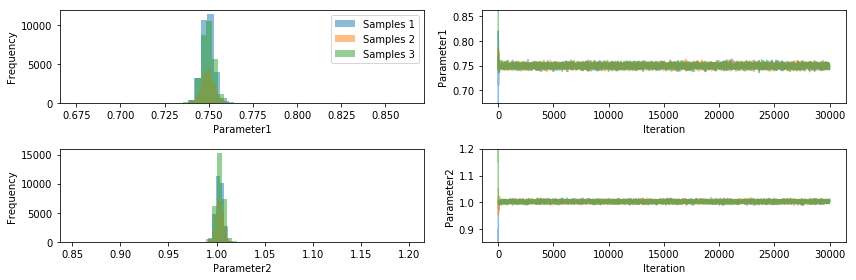

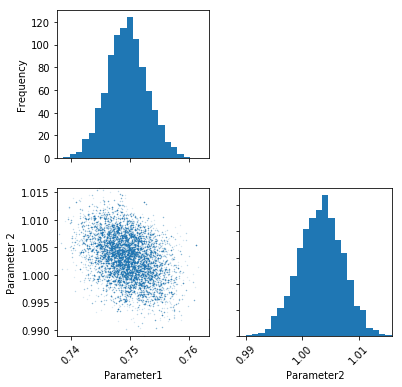

In [50]:
# Choose starting points for 3 mcmc chains
x0s = [
    np.array(start_parameters) * 0.9,
    np.array(start_parameters) * 1.05, #1.1
    np.array(start_parameters) * 1.15,
]
# Choose a covariance matrix for the proposal step
sigma0 = [0.01, 0.01] #np.abs(true_parameters) * 5e-5

# Create mcmc routine
mcmc = pints.MCMCController(log_posterior, 3, x0s)

# Add stopping criterion
mcmc.set_max_iterations(30000)

# Disable logging mode
#mcmc.set_log_to_screen(False)

# Run!
print('Running...')
ac_chains = mcmc.run()
print('Done!')

# Show traces and histograms
pints.plot.trace(ac_chains)

# Discard warm up
ac_chains_thinned = ac_chains[:, 10000:, :]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(ac_chains_thinned))

# Look at distribution in chain 0
pints.plot.pairwise(ac_chains_thinned[0])

# Show graphs
plt.show()

In [51]:
metropolis_chains.shape

(3, 30000, 2)

In [52]:
metropolis_chains[0][:10]

array([[0.675     , 0.9       ],
       [0.675     , 0.9       ],
       [0.67701386, 0.90353106],
       [0.67701386, 0.90353106],
       [0.67792129, 0.90368163],
       [0.68090666, 0.90062041],
       [0.68090666, 0.90062041],
       [0.68090666, 0.90062041],
       [0.68115302, 0.90250865],
       [0.68115302, 0.90250865]])

In [53]:
emulated_chains[0][:10]

array([[0.675     , 0.9       ],
       [0.675     , 0.9       ],
       [0.675     , 0.9       ],
       [0.675     , 0.9       ],
       [0.675     , 0.9       ],
       [0.675     , 0.9       ],
       [0.675     , 0.9       ],
       [0.67982569, 0.89787506],
       [0.67982569, 0.89787506],
       [0.67982569, 0.89787506]])

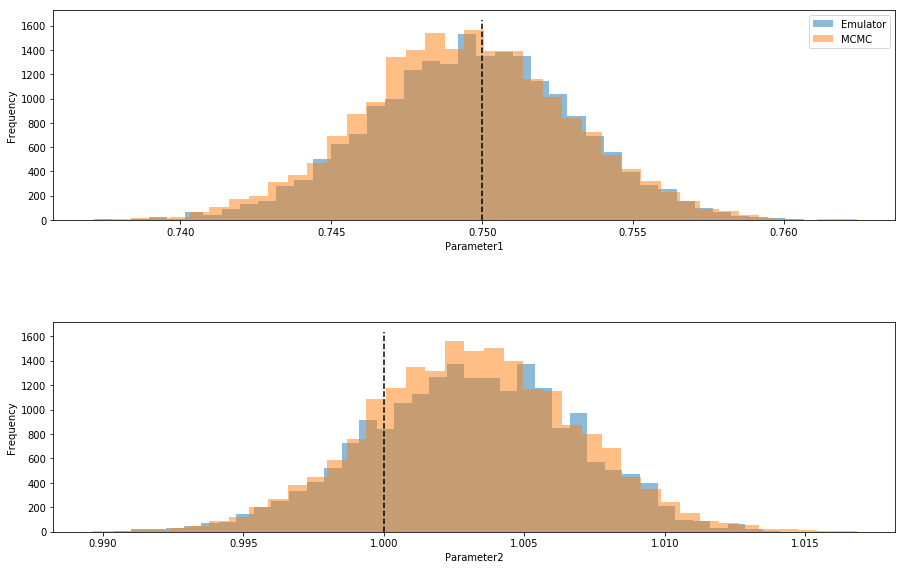

In [54]:
fig, axes = pints.plot.histogram([emulated_chains_thinned[0], metropolis_chains_thinned[0]], ref_parameters=start_parameters, sample_names=["Emulator", "MCMC", "2-Step procedure"])
fig.set_size_inches(14, 9)
plt.show()